In [474]:
#model for ASL project
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import itertools
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
import time
from tensorflow.keras.callbacks import Callback
from keras.callbacks import EarlyStopping

#CHANGE FOR FINAL SUBMISSION TO BE ABLE TO RUN
csv_file_path_train = '/Users/sofiautoft/ML/sign_mnist_train.csv'
csv_file_path_test = '/Users/sofiautoft/ML/sign_mnist_test.csv'

train_data = pd.read_csv(csv_file_path_train)
test_data = pd.read_csv(csv_file_path_test)

print(train_data.shape)
train_data.head()

(27455, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [475]:
print(test_data.shape)
test_data.head()

(7172, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [476]:
#put labels into y variable
Y_train = train_data["label"]
Y_test = test_data["label"]

#remove label from input
X_train = train_data.drop(labels = ["label"],axis = 1)
X_test = test_data.drop(labels = ["label"],axis = 1) 

Text(0.5, 0, 'letters')

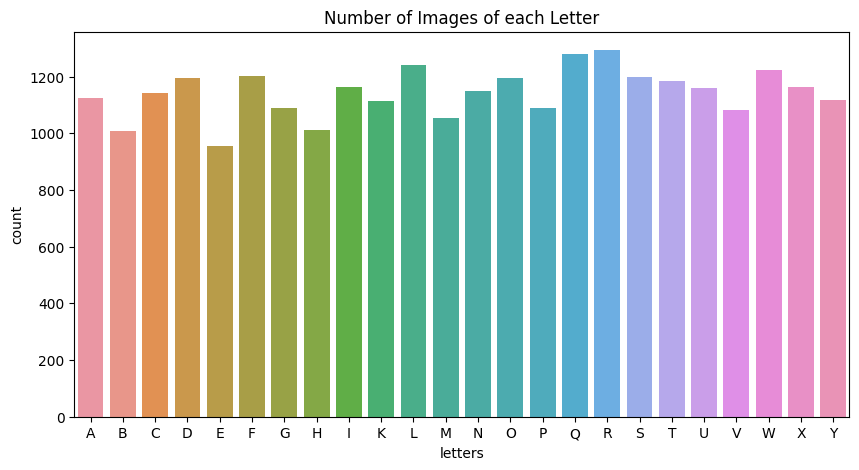

In [513]:
#create dictionary to go from number -> alphabetical letter
num_to_letters = {}
for num in range(0, 25):
    letter = chr(num + 65)
    num_to_letters[num] = letter

Y_train_labels = [num_to_letters[num] for num in Y_train]

Y_train_labels = sorted(Y_train_labels)

#visualize number of letters classes
plt.figure(figsize=(10,5))
g = sns.countplot(x = Y_train_labels)
plt.title("Number of Images of each Letter")
plt.xlabel("letters")
#no data for 'J' = 9 and 'Z' 25 since they are motions


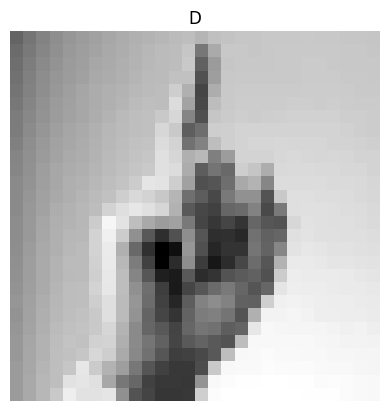

In [478]:
#plot a sample
img = X_train.iloc[0].values
img = img.reshape((28,28))
plt.imshow(img, cmap='gray')
key = train_data.iloc[0,0]
plt.title(num_to_letters[key])
plt.axis("off")
plt.show()

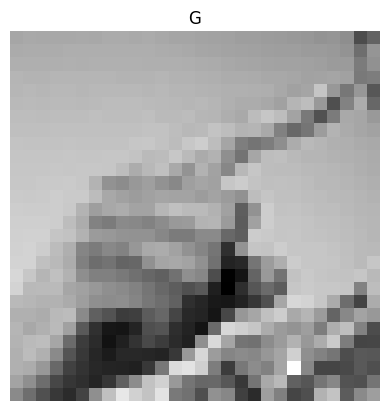

In [479]:
img = X_train.iloc[1].values
img = img.reshape((28,28))
plt.imshow(img, cmap='gray')
key = train_data.iloc[1,0]
plt.title(num_to_letters[key])
plt.axis("off")
plt.show()

In [480]:
#normalize the data (must be between 0 and 1 to feed our model)
X_train = X_train / 255.0
X_test = X_test / 255.0
print("x_train shape: ",X_train.shape)
print("test shape: ",X_test.shape)

x_train shape:  (27455, 784)
test shape:  (7172, 784)


In [481]:
#reshape the data into 28x28
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)
print("x_train shape: ",X_train.shape)
print("test shape: ",X_test.shape)

x_train shape:  (27455, 28, 28, 1)
test shape:  (7172, 28, 28, 1)


In [482]:
#one hot encoding
Y_train_encoded = to_categorical(Y_train, num_classes = 25)
Y_test_encoded = to_categorical(Y_test, num_classes=25)

In [483]:
'''accuracies listed were tested with an epoch size of 19'''

#define the model
model = Sequential()

#filters: 8 -> accuracy: 0.8917. filters: 32 -> accuracy: 0.9306
model.add(Conv2D(filters = 32, #the number of filters in the convolution
                 #kernel_size: (3,3) -> accuracy: 0.9279. kernel_size: (5,5) -> accuracy: 0.9543.
                 kernel_size = (5,5), #the size of the convolution window
                 padding = 'Same', #makes the output have the same size as the input
                 activation ='relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2))) #factors by which to downscale (dim1, dim2)
#stride (how the window is shifted along each dimension) is the same as pool_size since not specified
#dropout: 0.25 -> accuracy: 0.8454 0.8390 0.8214. dropout: 0.30 -> accuracy: 0.8951 0.0.8740 0.8664. dropout: 0.35 -> accuracy: 0.8404 0.8047 0.8021.
model.add(Dropout(0.30))

model.add(Conv2D(filters = 16, 
                 #kernel_size: (3,3) -> accuracy: 0.9091. kernel_size: (5,5) -> accuracy: 0.9543. kernel_size: (8,8) -> accuracy: 0.9511.
                 kernel_size = (5,5), 
                 padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2))) 
#dropout: 0.25 -> accuracy: 0.8454 0.8390 0.8214. dropout: 0.30 -> accuracy: 0.8951 0.0.8740 0.8664. dropout: 0.35 -> accuracy: 0.8404 0.8047 0.8021.
model.add(Dropout(0.30))

model.add(Flatten()) #flattens the input
model.add(Dense(256, activation = "relu"))
#dropout: 0.3 -> accuracy: 0.8067. dropout: 0.50 -> accuracy: 0.8678. dropout: 0.6 -> accuracy: 0.8162.
model.add(Dropout(0.5))

model.add(Dense(25, activation = "softmax"))

In [484]:
#optimze
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, 
                                            beta_1=0.9, #the exponential decay rate for the 1st moment estimates. 
                                            beta_2=0.999) #the exponential decay rate for the 2nd moment estimates.
#lr: 0.001 -> accuracy: 0.9060. lr: 0.01 -> accuracy: 0.6683

#optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.01) #lr: 0.001 -> accuracy: 0.0255. lr: 0.01 -> accuracy: 0.0673

#compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

#calculate the epochs & batch size
data = X_train.shape[0]
epochs = 85 #whole number options = 1, 5, 17, 19, 85, 95
batch_size = int(data / epochs)

In [485]:
#data augmentation
datagen = ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, 
        rotation_range=5,  #randomly rotate images 5 degrees
        zoom_range = 0.1, #randomly zoom in 10%
        width_shift_range=0.1,  #randomly shift images horizontally 10%
        height_shift_range=0.1,  #randomly shift images vertically 10%
        horizontal_flip=False,  #randomly flip images set to false - could this affect the sign if True (?)
        vertical_flip=False)  #randomly flip images set to false - could this affect the sign if True (?)

datagen.fit(X_train)

In [486]:
X_train.shape
Y_train_encoded.shape

(27455, 25)

In [487]:
#keep track of how long training takes
class TrainingTimeCallback(Callback):
    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        end_time = time.time()
        training_duration = end_time - self.start_time
        print("Training duration:", training_duration, "seconds")

#create an instance of the custom callback
time_callback = TrainingTimeCallback()

In [488]:
#calculate the stpes per epoch
steps_per_epoch = int(X_train.shape[0] / batch_size)

#define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience = 2, verbose=1, min_delta = 0.01, restore_best_weights = True)

#fit the model
history = model.fit(datagen.flow(X_train, Y_train_encoded, batch_size=batch_size), epochs=epochs, 
                    validation_data=(X_test, Y_test_encoded), steps_per_epoch=steps_per_epoch, callbacks=[time_callback, early_stopping])

Epoch 1/85
85/85 [==============================] - 17s 195ms/step - loss: 2.9395 - accuracy: 0.1253 - val_loss: 2.0222 - val_accuracy: 0.4329
Epoch 2/85
85/85 [==============================] - 15s 177ms/step - loss: 1.9124 - accuracy: 0.3966 - val_loss: 0.9948 - val_accuracy: 0.7306
Epoch 3/85
85/85 [==============================] - 16s 186ms/step - loss: 1.2628 - accuracy: 0.5841 - val_loss: 0.6280 - val_accuracy: 0.8136
Epoch 4/85
85/85 [==============================] - 15s 180ms/step - loss: 0.9687 - accuracy: 0.6763 - val_loss: 0.4733 - val_accuracy: 0.8565
Epoch 5/85
85/85 [==============================] - 25s 298ms/step - loss: 0.8110 - accuracy: 0.7277 - val_loss: 0.3690 - val_accuracy: 0.9041
Epoch 6/85
85/85 [==============================] - 21s 240ms/step - loss: 0.7006 - accuracy: 0.7648 - val_loss: 0.2901 - val_accuracy: 0.9250
Epoch 7/85
85/85 [==============================] - 18s 208ms/step - loss: 0.5973 - accuracy: 0.8002 - val_loss: 0.2319 - val_accuracy: 0.9317

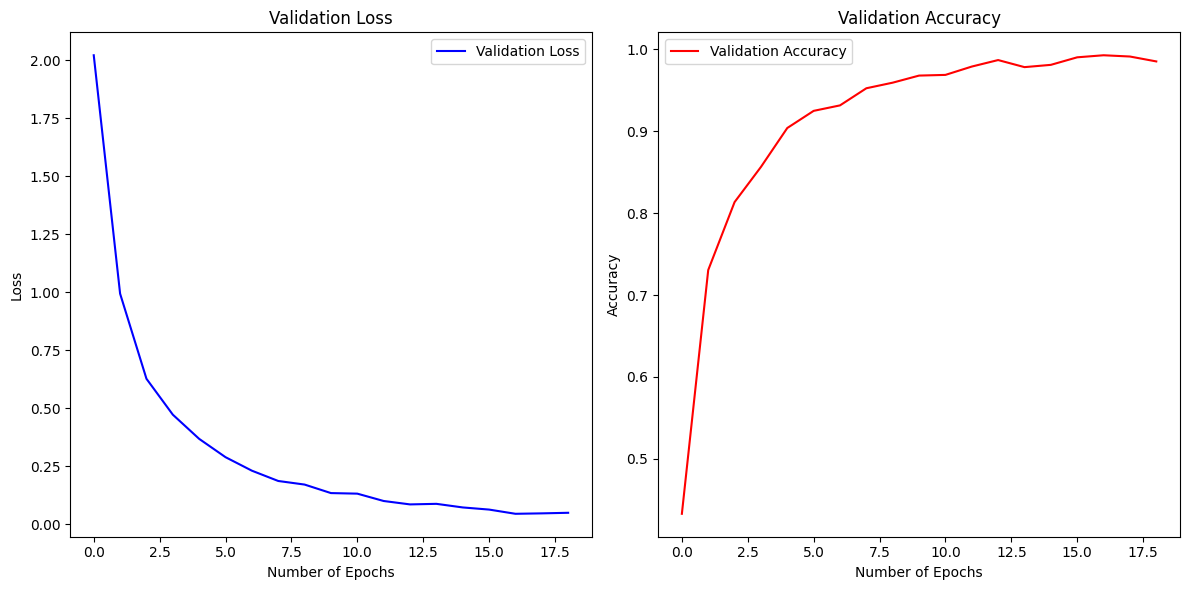

In [512]:
plt.figure(figsize=(12, 6))

#plot validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], color='b', label="Validation Loss")
plt.title("Validation Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()

#plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], color='r', label="Validation Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

225/225 [==============================] - 1s 3ms/step
Number of misclassifications:  51


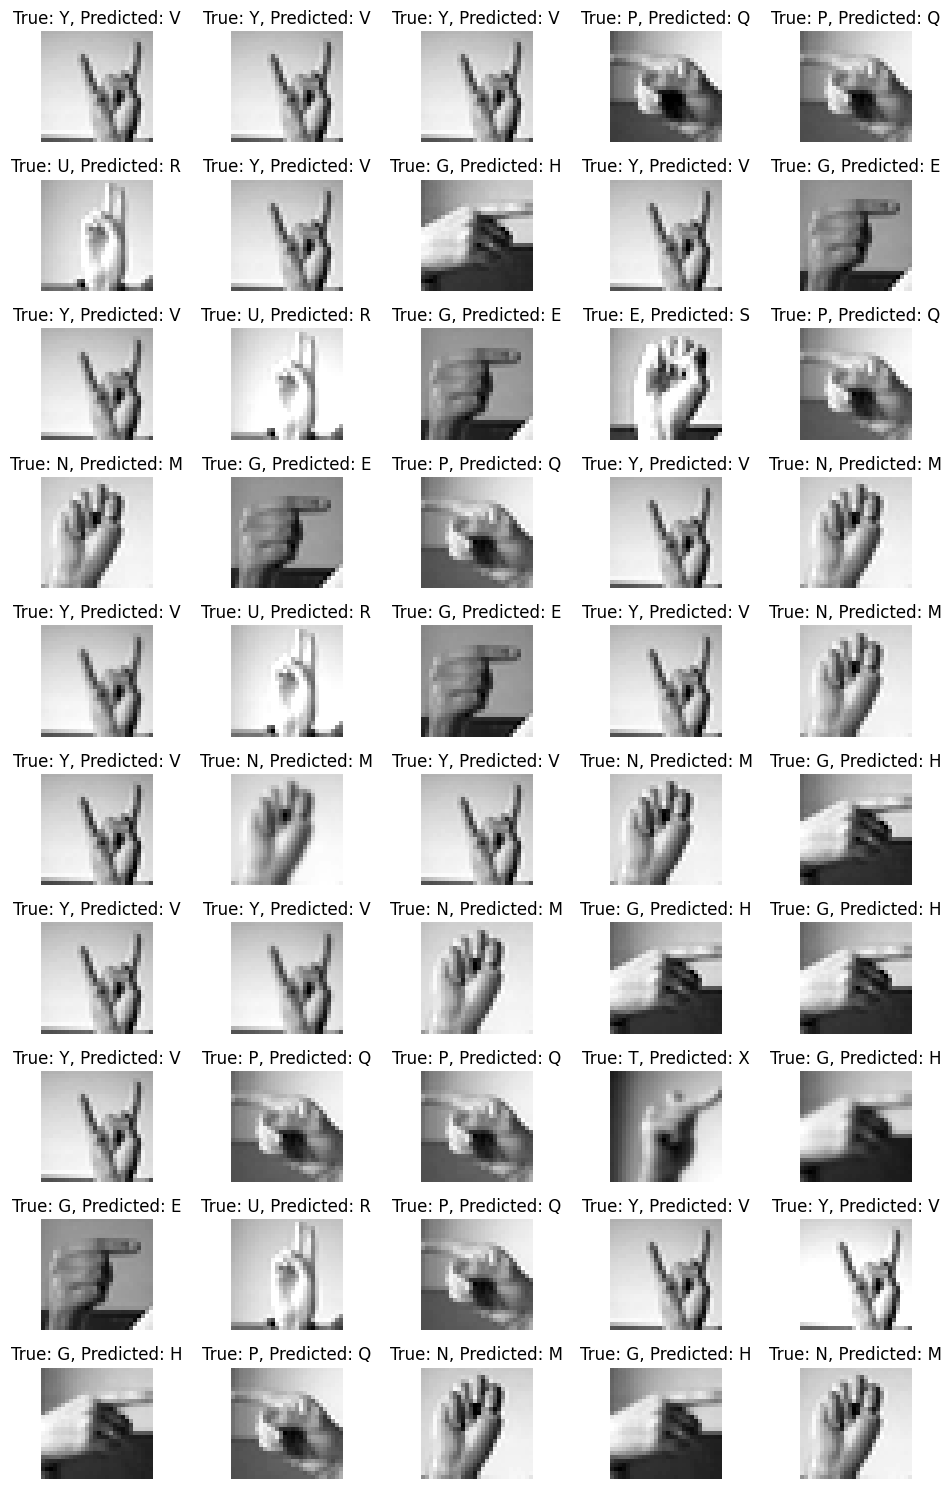

In [519]:
Y_pred = model.predict(X_test)
Y_test_labels = [num_to_letters[label] for label in Y_test]

#find misclassified indices
misclassified_indices = []
for i in range(len(Y_test)):
    if np.argmax(Y_pred[i]) != (Y_test[i]):
        misclassified_indices.append(i)
print("Number of misclassifications: " , len(misclassified_indices))

'''
#visualize misclassified images individually
for i in misclassified_indices:
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    true_label = num_to_letters[Y_test[i]]
    predicted_label = num_to_letters[np.argmax(Y_pred[i])]
    plt.title(f"True: {true_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()'''

#visualize misclassified images all at once
plt.figure(figsize=(10, 15))
for i, index in enumerate(misclassified_indices[:50]):
    plt.subplot(10, 5, i + 1)
    plt.imshow(X_test[index].reshape(28, 28), cmap='gray')
    true_label = Y_test_labels[index]
    predicted_label = num_to_letters[np.argmax(Y_pred[index])]
    plt.title(f"True: {true_label}, Predicted: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

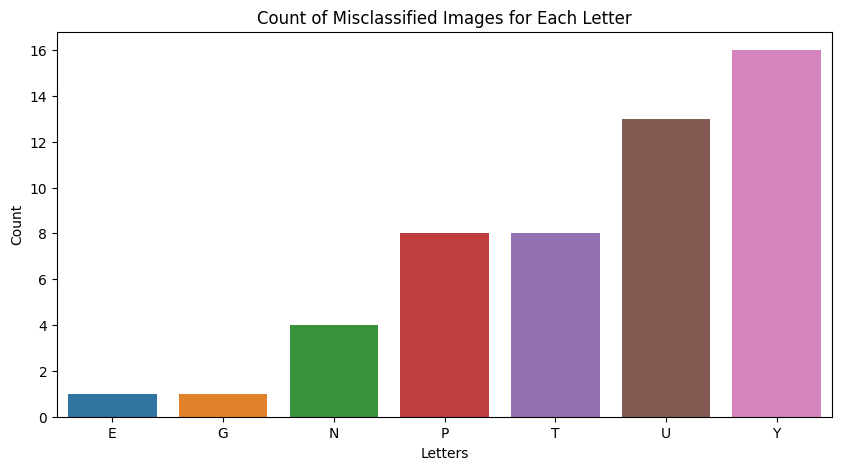

In [507]:
#convert numerical labels in Y_pred to alphabetical letters
Y_pred_labels = [num_to_letters[np.argmax(pred)] for pred in Y_pred]

#count the number of misclassified images for each letter
misclassified_counts = {}
for true_label, pred_label in zip(Y_test_labels, Y_pred_labels):
    if true_label != pred_label:
        misclassified_counts[true_label] = misclassified_counts.get(true_label, 0) + 1

# Plot the count of misclassified images for each letter
plt.figure(figsize=(10, 5))
sns.barplot(x=sorted(list(misclassified_counts.keys())), y=sorted(list(misclassified_counts.values())))
plt.title("Count of Misclassified Images for Each Letter")
plt.xlabel("Letters")
plt.ylabel("Count")
plt.show()


In [491]:
#save trained model
""" from tensorflow.keras.models import save_model

model.save("my_model.h5")  # Save the model to a file named "my_model.h5"
 """

' from tensorflow.keras.models import save_model\n\nmodel.save("my_model.h5")  # Save the model to a file named "my_model.h5"\n '